## Poisson model

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from theano import tensor as ts
import pymc3 as pm

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (8,6)

In [2]:
#from blaze import Data
#from odo import odo

#t = Data("sqlite:///data.sqlite3::test")
#usecols = ["week_num","agency_id","product_id","adjusted_demand"]
#t = t[usecols]
#t = t.sample(n=20000)
#odo(t, "downloads/train-samp-20k.csv")

In [3]:
train_samp = pd.read_csv("downloads/train-samp-20k.csv")
train_samp.head()

,week_num,agency_id,product_id,adjusted_demand
0,6,1462,43058,5
1,7,22560,1250,4
2,3,2015,1309,3
3,7,2653,42434,4
4,3,1381,1240,28


In [4]:
n_weeks = len(train_samp.week_num.unique())
n_products = len(train_samp.product_id.unique())
n_agencies = len(train_samp.agency_id.unique())

In [5]:
print("Number of weeks: {}\n Number of products: {}\n Number of agencies {}".format(n_weeks,n_products,n_agencies))

Number of weeks: 7
 Number of products: 645
 Number of agencies 485


In [6]:
week_lb = LabelEncoder()
week_code = week_lb.fit_transform(train_samp.week_num)

agency_lb = LabelEncoder()
agency_code = agency_lb.fit_transform(train_samp.agency_id)

product_lb = LabelEncoder()
product_code = product_lb.fit_transform(train_samp.product_id)

In [7]:
week_code

array([3, 4, 0, ..., 5, 0, 0])

In [8]:
product_code

array([469,  54,  58, ...,  66, 407, 517])

In [9]:
agency_code

array([155, 475, 320, ..., 295, 285, 148])

### Error metrics

#### Root Mean Squared Logarithmic Error

$\epsilon$ = $\sqrt{\frac{1}{n} \sum_{i=1}^{n} (\log(p_i + 1) - \log(a_i + 1))^2}$

Ref: https://www.kaggle.com/wiki/RootMeanSquaredLogarithmicError

In [10]:
def rmsle(resp, pred):
    n = len(resp)
    return np.sqrt(np.sum(np.square(np.log(pred + 1) - np.log(resp + 1)))/n)

In [11]:
rmsle(np.array([1,2,3]), np.array([1,2,4]))

0.12883198941918803

In [12]:
rmsle(np.array([1,2,3]), np.array([1,2,3]))

0.0

In [13]:
pois_model = pm.Model()

with pois_model:
    week_rate = pm.HalfNormal("week_rate", sd=10, shape=n_weeks)
    agency_rate = pm.HalfNormal("agency_rate", sd=10, shape=n_agencies)
    product_rate = pm.HalfNormal("product_rate", sd=10, shape=n_products)
    demand_rate = week_rate[week_code] + product_rate[product_code] + agency_rate[agency_code]
    adjusted_demand = pm.Poisson("adjusted_demand", mu=demand_rate, observed=train_samp.adjusted_demand)

Applied log-transform to week_rate and added transformed week_rate_log to model.
Applied log-transform to agency_rate and added transformed agency_rate_log to model.
Applied log-transform to product_rate and added transformed product_rate_log to model.


In [14]:
with pois_model:
    means, sds, elbos = pm.advi(n=10000)

Iteration 0 [0%]: ELBO = -698980.53
Iteration 1000 [10%]: ELBO = -457082.48
Iteration 2000 [20%]: ELBO = -288117.34
Iteration 3000 [30%]: ELBO = -236305.57
Iteration 4000 [40%]: ELBO = -192578.34
Iteration 5000 [50%]: ELBO = -136389.94
Iteration 6000 [60%]: ELBO = -120880.1
Iteration 7000 [70%]: ELBO = -109496.74
Iteration 8000 [80%]: ELBO = -102448.58
Iteration 9000 [90%]: ELBO = -100282.91
Finished [100%]: ELBO = -97916.7


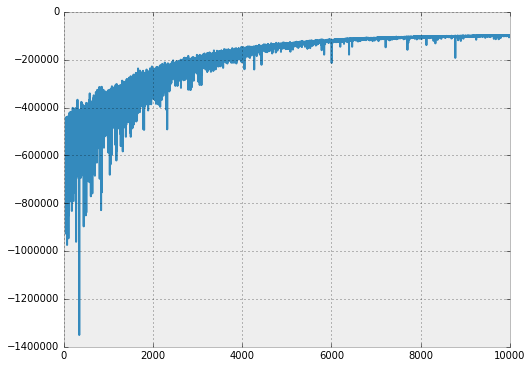

In [15]:
plt.plot(elbos)

In [17]:
with pois_model:
    step = pm.NUTS(scaling=means)
    trace_pois = pm.sample(500, step=step)

 [-----------------100%-----------------] 500 of 500 complete in 108.5 sec

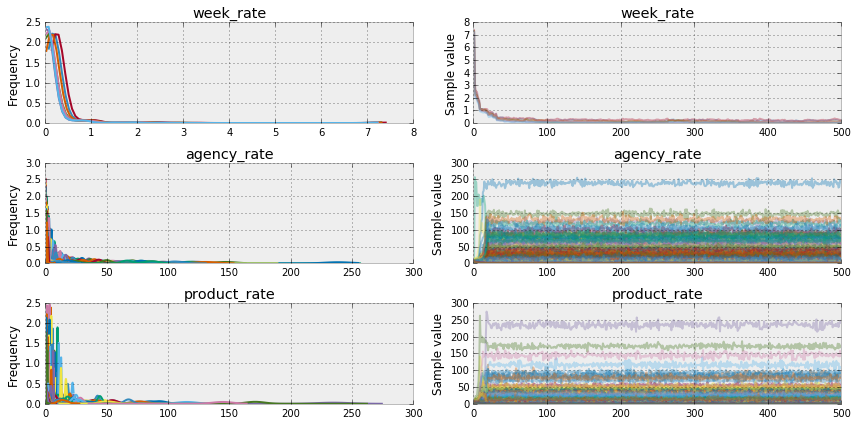

In [18]:
_ = pm.traceplot(trace_pois)

In [19]:
pred_demand = pm.sample_ppc(trace_pois, model=pois_model)["adjusted_demand"]

In [20]:
errors = np.array([rmsle(train_samp.adjusted_demand.values, s) for s in pred_demand])

In [21]:
np.mean(errors)

0.79778410658812615

In [22]:
rmsle(train_samp.adjusted_demand.values, np.mean(pred_demand, axis=0))

0.69498847778834905

In [23]:
np.median(errors)

0.79270497860044808

In [24]:
rmsle(train_samp.adjusted_demand.values, np.median(pred_demand, axis=0))

0.68587441273842531

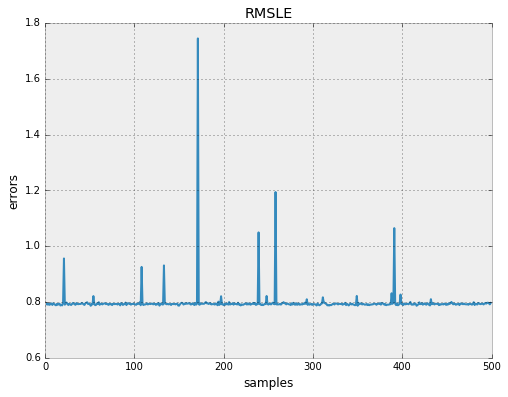

In [25]:
plt.plot(errors)
plt.title("RMSLE")
plt.xlabel("samples")
plt.ylabel("errors")

In [26]:
def plot_ppc(ppc_var, name="median"):
    funs = {"mean":np.mean, "median":np.median}
    f = funs[name]
    n_samp = ppc_var.shape[0]
    fig,axs = plt.subplots(nrows=1, ncols=2, figsize=(15,6), sharey=True)

    axs[0].hist(train_samp.adjusted_demand, bins=20, log=True)
    axs[0].set_title("Observed data")

    axs[1].hist(f(ppc_var, axis=0), bins=20)
    axs[1].set_title("Posterior %s (%d samples)" % (name, n_samp))

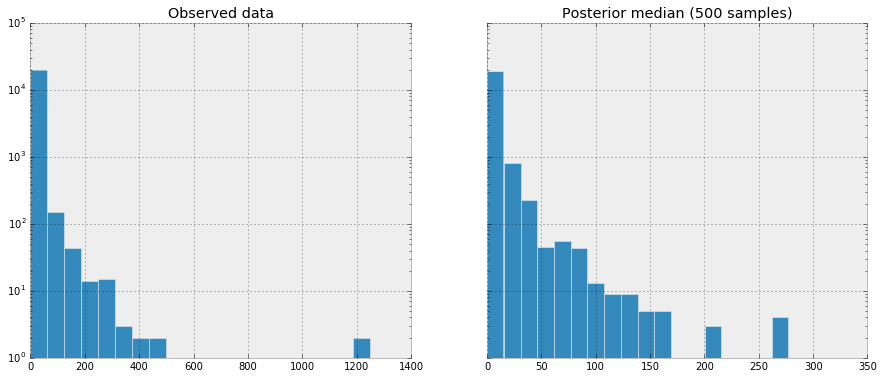

In [27]:
plot_ppc(pred_demand)

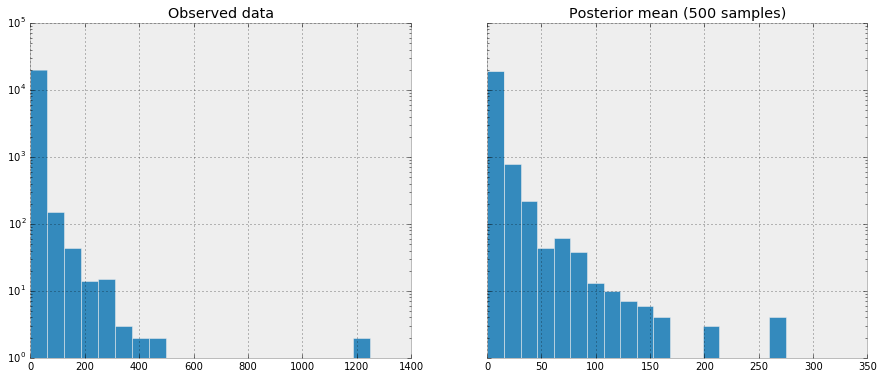

In [28]:
plot_ppc(pred_demand, name="mean")